# Loading data

In [1]:
import h5py
import numpy as np
import tonic

drone_data = h5py.File('/home/aric/adasi/data/2025-07-17-12-49-53_full_testing.h5', 'r')
shapes_data = h5py.File('/home/aric/adasi/data/2025-08-10-18-39-47.h5', 'r')

drone_events = drone_data['events_data'][:]

def arr_to_struct(arr): 
    #we will cover tonic later. For now just know that it is a format for storing events that is more memory efficient.
    out = np.zeros(len(arr), dtype=[('x', '<i2'), ('y', '<i2'), ('p', '?'), ('t', '<f8')])
    # arr[:, 3] = arr[:, 3] 
    arr[:, 3] = arr[:, 3] - arr[0, 3]
    
    out['x'] = arr[:, 0].astype(np.int16)
    out['y'] = arr[:, 1].astype(np.int16)
    out['p'] = arr[:, 2].astype(bool)
    out['t'] = arr[:, 3].astype(np.float64)
    return out

drone_events = arr_to_struct(drone_events)

print("We have {} events".format(len(drone_events)))

We have 127587463 events


In [2]:
#first and last 5 events
print("First 5 events:")
print(drone_events[:5])
print("Last 5 events:")
print(drone_events[-5:])

First 5 events:
[(254,  24, False, 0.0e+00) (334, 209,  True, 1.3e-05)
 (184, 131,  True, 2.3e-05) (207, 152,  True, 2.3e-05)
 (276,  50, False, 3.0e-05)]
Last 5 events:
[(338, 253, False, 258.462961) (224,  83, False, 258.462963)
 (224,  23,  True, 258.46297 ) (211,  47,  True, 258.462977)
 ( 25, 137, False, 258.462978)]


## Event processing preliminary

Processing neuromorphic event-based datasets is much different than what you're probably used to. Event data is 

1. Temporally asynchronous (unlike typical video data) and dense
2. Spatially sparse (unlike typical images)

You can see from above that we have a list of more than a million events over the span of only ~300 seconds. How do we about understanding this data? Let's first try to understand the temporal aspect of this data

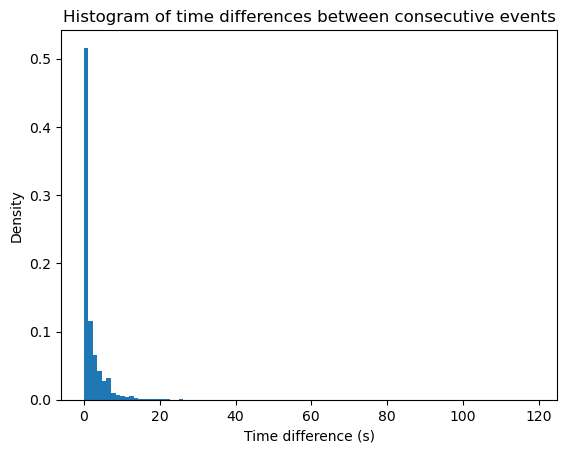

In [3]:
import matplotlib.pyplot as plt

#differences in time between consecutive events
diffs = np.diff(drone_events['t'])

plt.hist(diffs*1e6, bins=100, density=True)
plt.xlabel('Time difference (s)')
plt.ylabel('Density')
plt.title('Histogram of time differences between consecutive events')
plt.show()

You can see that most events are less than 20 microseconds away from the next event. This indeed confirms that event data is temporally dense. Let's try to understand which periods of time have the most events. Intution tells us that these regions should correspond to motion in the scene.

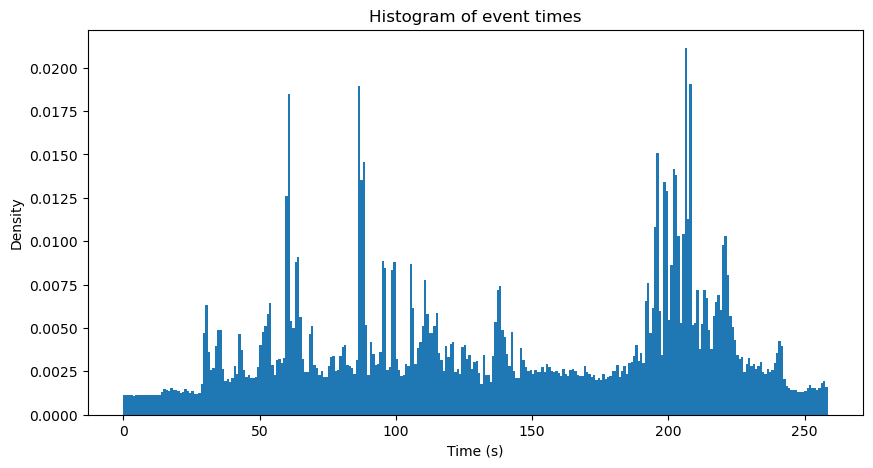

In [4]:
plt.figure(figsize=(10, 5))
plt.hist(drone_events['t'], bins=300, density=True)
plt.xlabel('Time (s)')
plt.ylabel('Density')
plt.title('Histogram of event times')
plt.show()

We can see that after 40 seconds there was lots of events, indicating that there was motion at that time. Notice how this histogram is highly nonuniform as event data is asynchronous. Let's try to extract the events between seconds 40 and 45.

In [5]:
def get_events_between(events, t0, t1):
    idx = np.where((events['t'] >= t0) & (events['t'] <= t1))[0]
    out = events[idx]
    return out

t0 = 40
t1 = 45

sample = get_events_between(drone_events, t0, t1)

print("Number of events between {} and {} seconds: {}".format(t0, t1, len(sample)))

Number of events between 40 and 45 seconds: 1957473


One day to visualize these events to simply put a red pixel where a negative event has happened and a blue where a positive event has happened. Let's initialize an empty image and do that.

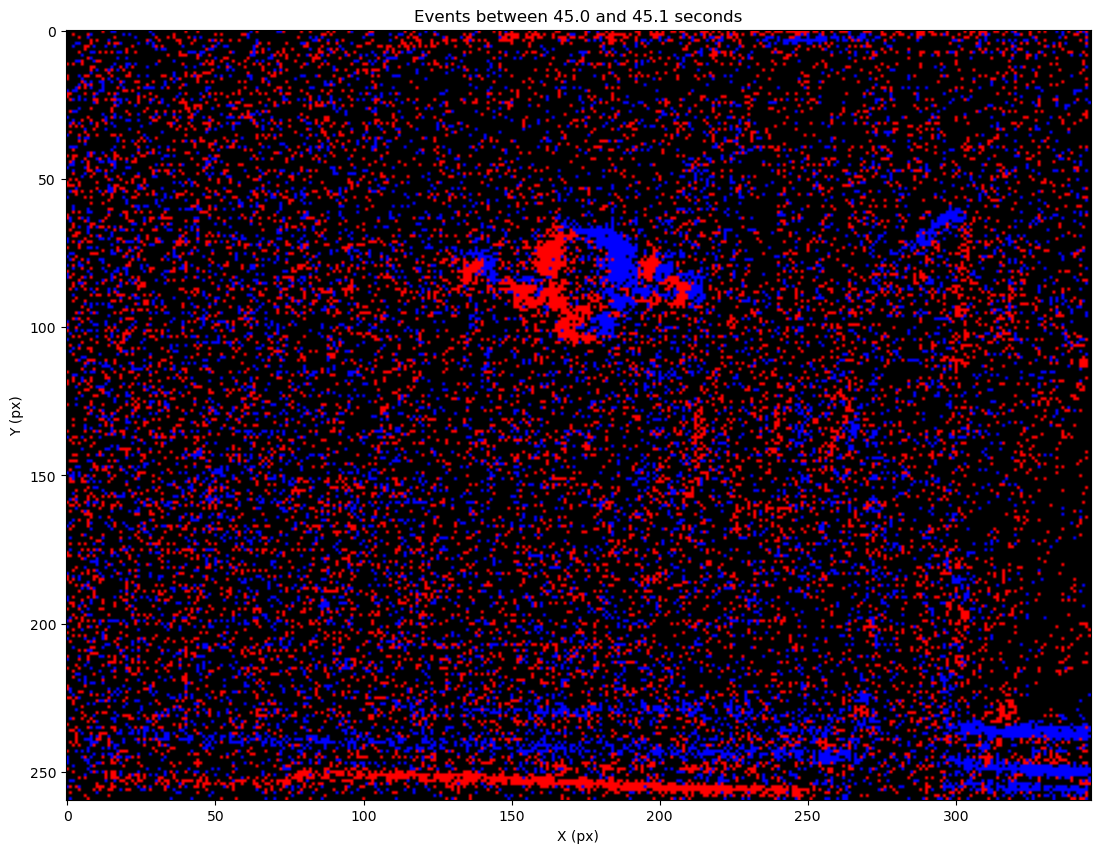

In [10]:
img = np.zeros((260, 346, 3), dtype=np.uint8) # W x H x C
# Initialize an empty image with 3 channels (RGB)
# Note: The dimensions (240, 346) should match the resolution of your event camera

for event in sample:
    x, y, p = event['x'], event['y'], event['p']
    if p:  # Positive event
        img[y, x, 0] = 255
        img[y, x, 1] = 0
        img[y, x, 2] = 0
    else:  # Negative event
        img[y, x, 0] = 0
        img[y, x, 1] = 0
        img[y, x, 2] = 255

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.title('Events between {} and {} seconds'.format(t0, t1))
plt.show()


Let's look at a smaller segment. Say from 45.0 to 45.1 seconds.

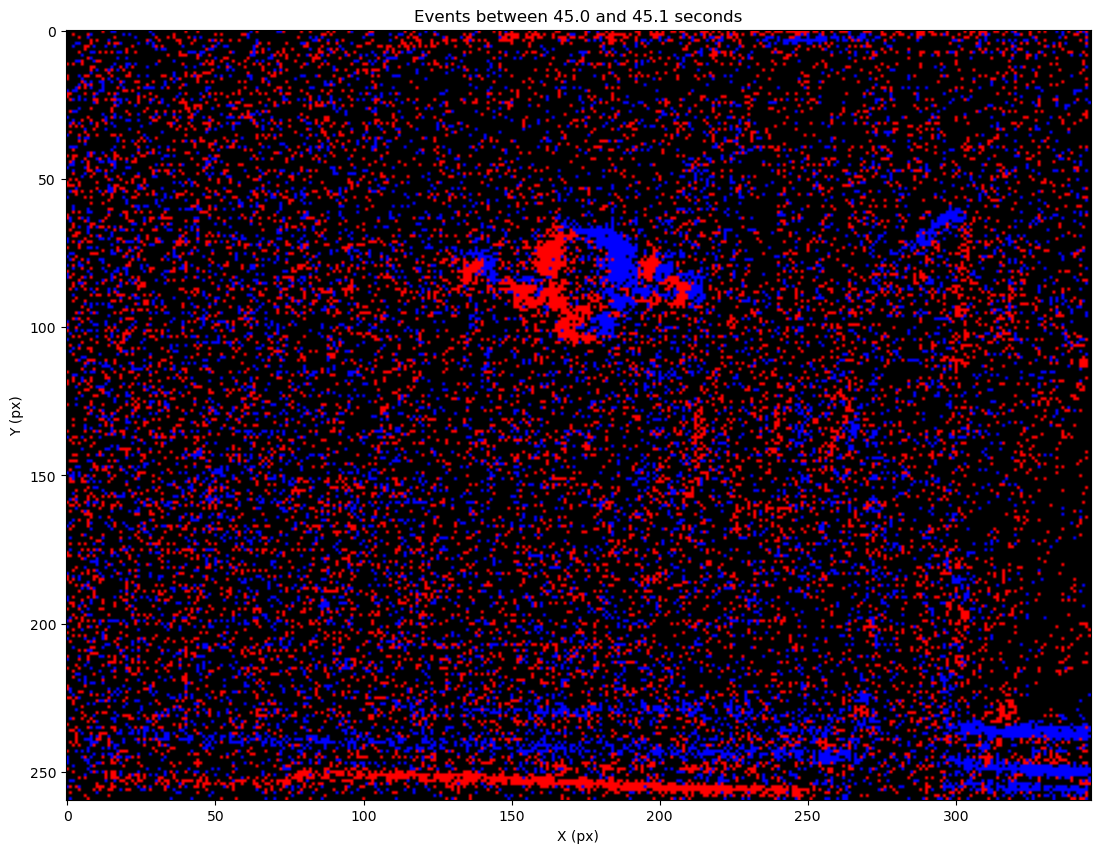

In [11]:
t0 = 45.0
t1 = 45.1

sample = get_events_between(drone_events, t0, t1)

img = np.zeros((260, 346, 3), dtype=np.uint8) # W x H x C

for event in sample:
    x, y, p = event['x'], event['y'], event['p']
    if p:  # Positive event
        img[y, x, 0] = 255
        img[y, x, 1] = 0
        img[y, x, 2] = 0
    else:  # Negative event
        img[y, x, 0] = 0
        img[y, x, 1] = 0
        img[y, x, 2] = 255

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.title('Events between {} and {} seconds'.format(t0, t1))
plt.show()

Number of events between 45.1 and 45.2 seconds: 27854


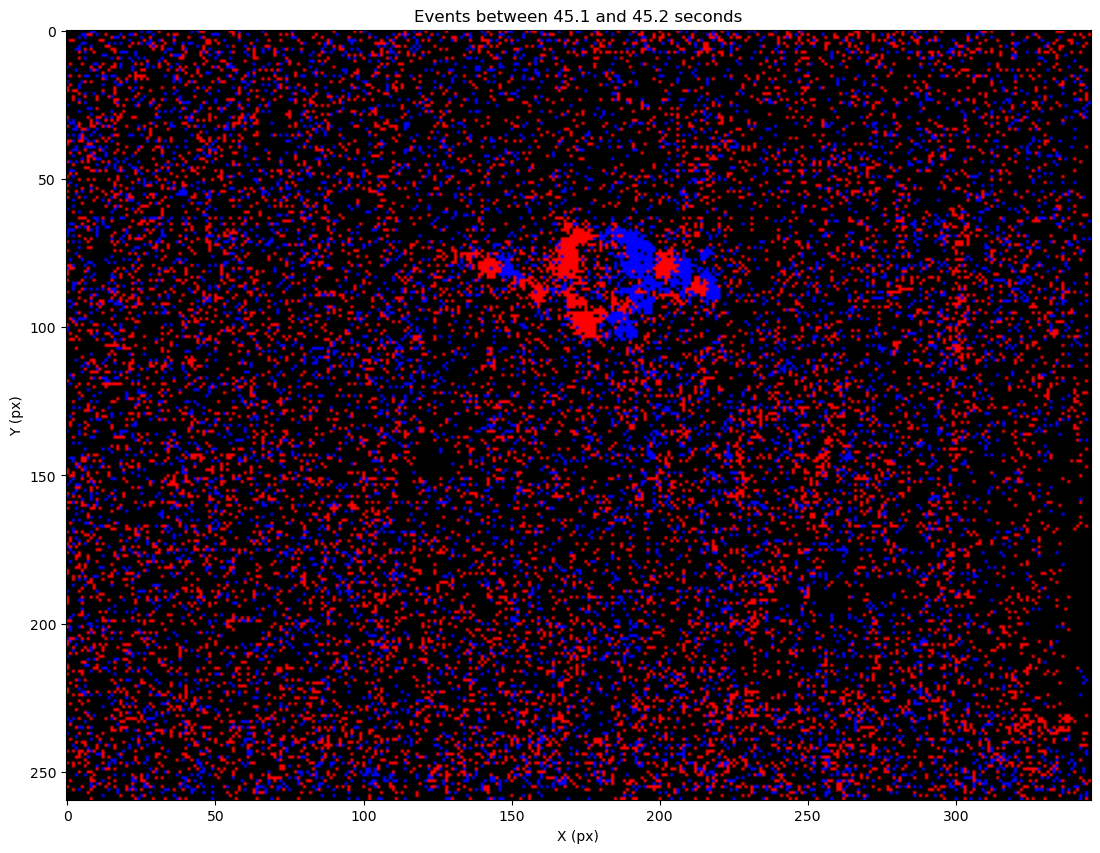

In [12]:
#Let's look at the next 0.1 seconds of events
t0 = 45.1
t1 = 45.2

sample = get_events_between(drone_events, t0, t1)

print("Number of events between {} and {} seconds: {}".format(t0, t1, len(sample)))

img = np.zeros((260, 346, 3), dtype=np.uint8) # W x H x C

for event in sample:
    x, y, p = event['x'], event['y'], event['p']
    if p:  # Positive event
        img[y, x, 0] = 255
        img[y, x, 1] = 0
        img[y, x, 2] = 0
    else:  # Negative event
        img[y, x, 0] = 0
        img[y, x, 1] = 0
        img[y, x, 2] = 255

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.title('Events between {} and {} seconds'.format(t0, t1))
plt.show()  

In [5]:
import matplotlib.pyplot as plt
ts0 = events[0]['t']
ts1 = events[-1]['t']

print("Time span: ", (ts1 - ts0), "seconds")

#30 ms windows
breaks = np.arange(ts0, ts1, 20e-3)
print("Number of 30 ms windows: ", len(breaks) - 1)

#count events in each window
#we can exploit the fact that the events are sorted by time by using numpy's searchsorted function to search for the indices of the breaks in the events array
breaks_idx = np.searchsorted(events['t'], breaks)
counts = np.diff(breaks_idx)

plt.plot(breaks[:-1] / 1e6, counts, label='Events per 30 ms')
plt.xlabel('Time (s)')
plt.ylabel('Number of events')

NameError: name 'events' is not defined

Your job now is to try and reproduce some the event-representations you saw in the slides on one of the 30ms windows you found above. 

## Reproduce the 3D plot

35.60000400000001 35.61999900000001


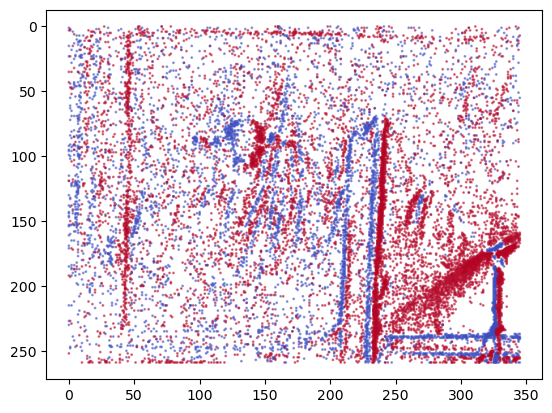

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#3D plot the events
window_idx = 1780

sample = events[breaks_idx[window_idx]:breaks_idx[window_idx + 1]]
print(sample['t'][0] , sample['t'][-1] )


plt.scatter(sample['x'], sample['y'], c=sample['p'], cmap='coolwarm', s=1, alpha=0.5)

# flip the y-axis to match the camera coordinate system
plt.gca().invert_yaxis()
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(sample['t'] / 1e6, sample['x'], sample['y'], c=sample['p'], cmap='coolwarm', s=1, alpha=0.5)
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('X')
# ax.set_zlabel('Y')
# plt.show()


## Reproduce the histogram without polarity

In [ ]:
#code to produce event frame histogram

## Reproduce the voxel grid with 4 bins

In [ ]:
#code to produce voxel grid

## Reproduce the average timestamps

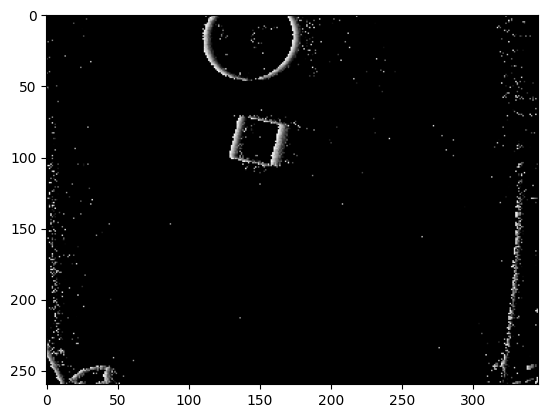

In [ ]:
%matplotlib inline

sample = events[breaks_idx[window_idx]:breaks_idx[window_idx + 1]]

F = np.zeros((260, 346, 1))
counts = np.zeros((260, 346, 1))

t_norm = (sample['t'] - sample['t'][0]) / (sample['t'][-1] - sample['t'][0])

for i, e in enumerate(sample):
    F[e['y'], e['x'], 0] = F[e['y'], e['x'], 0] + t_norm[i]
    counts[e['y'], e['x'], 0] = counts[e['y'], e['x'], 0] + 1

F = np.divide(F, counts, out=np.zeros_like(F), where=counts != 0)

plt.imshow(F[:, :, 0], cmap='gray')

In [ ]:
F.max()

1.0

In [ ]:
sample['t']

array([3300007.75, 3300016.  , 3300017.  , ..., 3329981.  , 3329984.  ,
       3329999.  ])

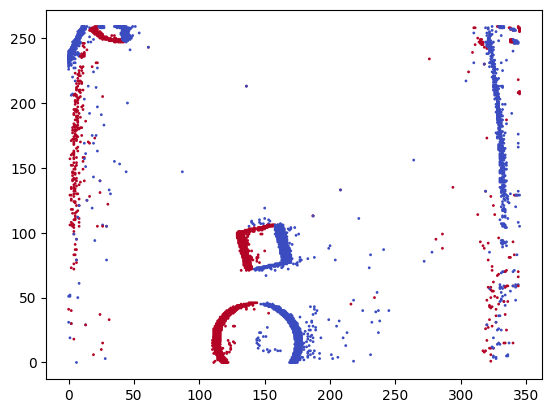

In [ ]:
plt.scatter(sample['x'], sample['y'], c=sample['p'], cmap='coolwarm', s=1)

In [ ]:
t_norm

array([0.00000000e+00, 2.75080232e-04, 3.08423290e-04, ...,
       9.99399825e-01, 9.99499854e-01, 1.00000000e+00])